# Econ 430 Project #3

**Group members**: Leonardo Livio Fancello, Hayden Johnson, Cade Foster, Quentin Bidwell

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats.outliers_influence as smo
import patsy as pt
import statsmodels.regression.linear_model as rg
import statsmodels.stats.diagnostic as dg
import linearmodels as plm
from RegscorePy import mallow
from BorutaShap import BorutaShap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from simple_colors import *

# Part 1 | Panel Data

# 1

**Unnamed: 0**: Index generated per state **state**: Name of state **colonies_number**: Number of honey producing colonies. Honey producing colonies are the maximum number of Number of colonies **yield_per_colony**: Honey yield per colony. Unit is pounds **production**: Total production obtained by multiplying colony_number by yield_per_colony. Unit is pounds **stocks**: Refers to stocks held by producers. Unit is pounds **average_price**: Refers to average price per pound based on expanded sales. Unit is dollars **value_of_production**: Value of production obtained by multiplying production and average_price. Unit is dollar **year**: Year of which data is tabulated

Our group wanted to continue the theme we began with our analysis on wine quality determinants with a product less studied and with more opportunities for disruption. Especially in LA, locally sourced and artisan honey has become a fad with honey prices rising 21% last year nationally (Flottum, via BeeCulture). Our group wanted to capture the classic scenario of optimizing an economic opportunity through statistics that has traditionally been left to the intuition and art of the commodity producers. Through our analysis, we hope to identify and quantify which elements of honey production can be used to increase the end result of the production– the average selling price. Through this project, we can shed analytical insight onto the true determinants of profitability for honey producers and could theoretically introduce efficiency and potentially disruption into the industry.

# 2

In [121]:
bee = pd.read_csv("US_honey_dataset_updated.csv")

In [100]:
bee.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1115.0,5.570000e+02,3.220171e+02,0.0,278.5,557.0,835.5,1114.0
colonies_number,1115.0,6.243857e+04,9.264818e+04,2000.0,9000.0,26000.0,69000.0,550000.0
yield_per_colony,1115.0,5.974350e+01,1.994050e+01,19.0,45.0,57.0,71.0,155.0
production,1115.0,2.851268e+06,5.561202e+06,12000.0,246000.0,828000.0,2700000.0,39060000.0
stocks,1115.0,1.172625e+06,2.049556e+06,9000.0,112500.0,370000.0,1253500.0,13545000.0
average_price,1115.0,1.406231e+02,1.070115e+02,1.3,70.0,128.0,193.0,874.0
value_of_production,1115.0,5.667412e+06,9.459460e+06,106000.0,1008000.0,2281000.0,5704000.0,83859000.0
year,1115.0,2.007741e+03,7.823002e+00,1995.0,2001.0,2008.0,2015.0,2021.0


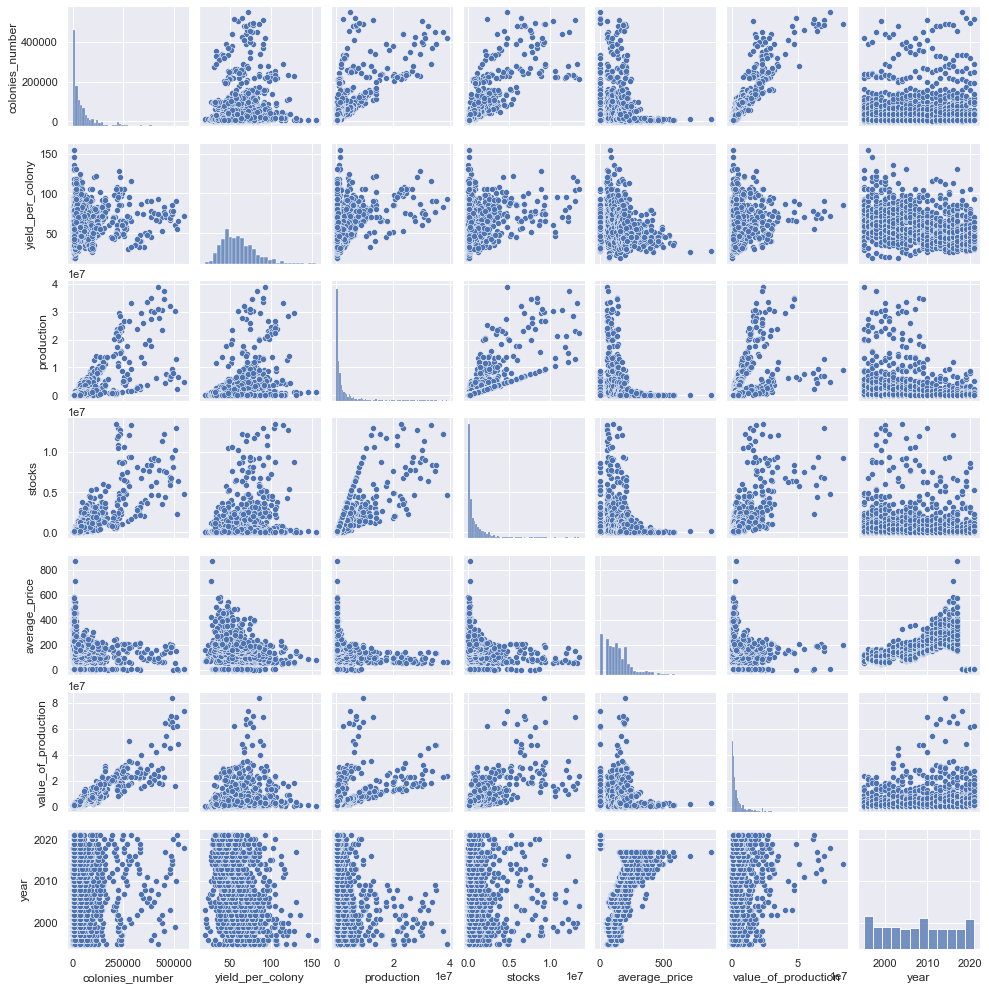

In [55]:
# Subsetting the data
subset = bee[['state', 'colonies_number', 'yield_per_colony', 'production', 'stocks', 
                 'average_price', 'value_of_production', 'year']]

# Creating a Pairplot for all of the quatitative variables 
sns.set()
sns.pairplot(subset, size = 2.0)
plt.show()

We can see the trends between the outcome and predictor variables are strong and there are not strong trends between predictors

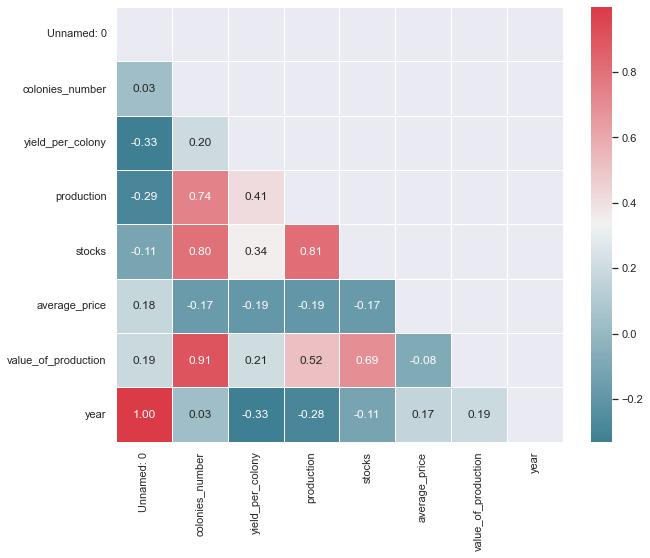

In [57]:
corr = bee.corr()
fig, ax = plt.subplots(figsize=(10, 8))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals)
plt.show()

As suspected, there is high correlation between a couple of predictors. Number of Colonies, stocks, production, 
and value of production are a couple of variables with relatively high correlation numbers between predictors.

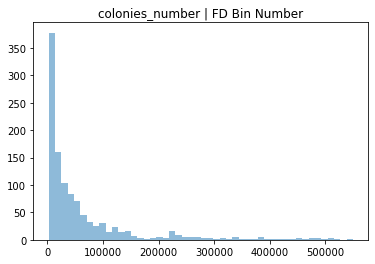

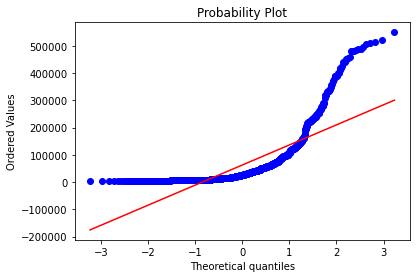

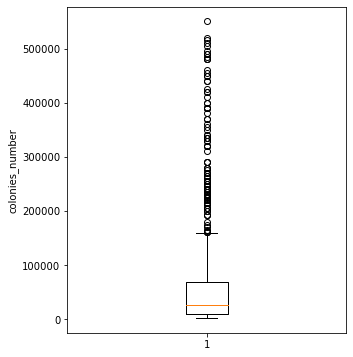

count      1115.000000
mean      62438.565022
std       92648.175955
min        2000.000000
25%        9000.000000
50%       26000.000000
75%       69000.000000
max      550000.000000
Name: colonies_number, dtype: float64

In [4]:
plt.hist(bee.colonies_number, alpha = .5, bins = "fd")
plt.title("colonies_number | FD Bin Number")
plt.show()
stats.probplot(bee.colonies_number, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(bee.colonies_number)
plt.ylabel("colonies_number")
plt.show()
bee.colonies_number.describe()

The histogram shows that the data is skewed to the right and it does not appear normally distributred. The QQ plot confirms this suspicion of the colonies_number not being normally distributed. The box plot shows large amounts of data points outside the upper extreme indicating many outliers. The standard deviation is larger than the mean; however, the median is much larger than both at 26000. The maximum is over 500,000 additional colonies.

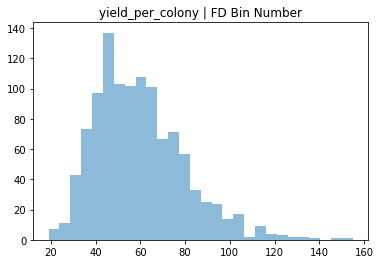

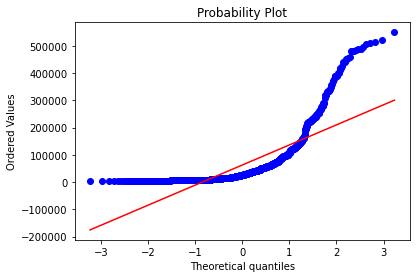

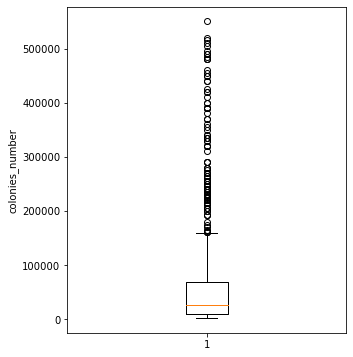

count    1115.000000
mean       59.743498
std        19.940500
min        19.000000
25%        45.000000
50%        57.000000
75%        71.000000
max       155.000000
Name: yield_per_colony, dtype: float64

In [5]:
plt.hist(bee.yield_per_colony, alpha = .5, bins = "fd")
plt.title("yield_per_colony | FD Bin Number")
plt.show()
stats.probplot(bee.colonies_number, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(bee.colonies_number)
plt.ylabel("colonies_number")
plt.show()
bee.yield_per_colony.describe()

The histogram appears to be slightly right skewed but it could potentially be normally distributed. The QQ plot describes the yield_per_colony as not being normally distributed. There are many outliers that lie beyond the upper extreme for the box plot. The minimum is almost the same as the standard deviation. The mean and median are relatively close to each other. The maximum is almost 3 times more than the mean and median.

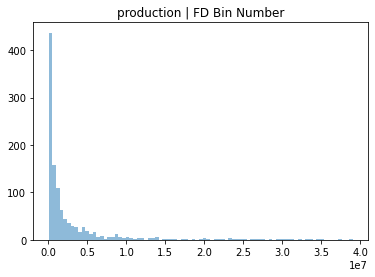

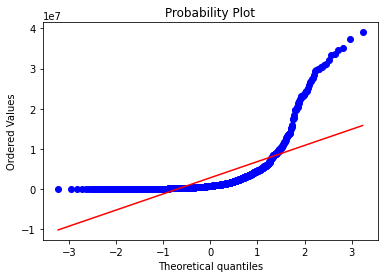

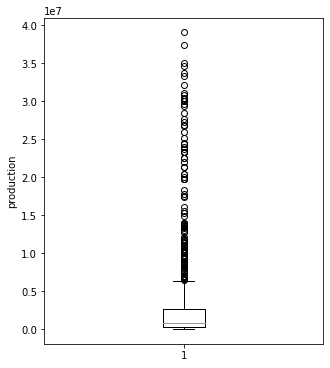

count    1.115000e+03
mean     2.851268e+06
std      5.561202e+06
min      1.200000e+04
25%      2.460000e+05
50%      8.280000e+05
75%      2.700000e+06
max      3.906000e+07
Name: production, dtype: float64

In [6]:
plt.hist(bee.production, alpha = .5, bins = "fd")
plt.title("production | FD Bin Number")
plt.show()
stats.probplot(bee.production, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(bee.production)
plt.ylabel("production")
plt.show()
bee.production.describe()

The histogram appears heavily right skewed and is not normally distributed. The QQ plot shows that the production is not normally distributed as the observations do not follow a straight line. The box plot shows a heavy amount of outliers above the upper extreme. The median is almost 10 times greater than the mean and the max is close to 100 times bigger than the mean. The standard deviation is larger than the mean.

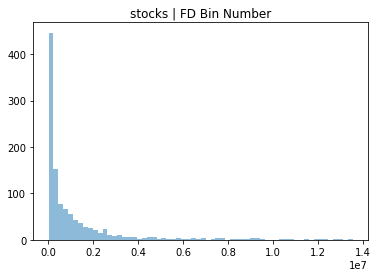

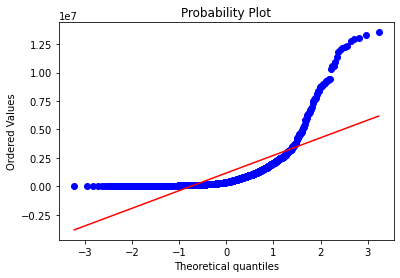

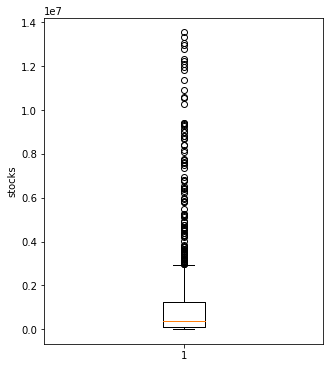

count    1.115000e+03
mean     1.172625e+06
std      2.049556e+06
min      9.000000e+03
25%      1.125000e+05
50%      3.700000e+05
75%      1.253500e+06
max      1.354500e+07
Name: stocks, dtype: float64

In [7]:
plt.hist(bee.stocks, alpha = .5, bins = "fd")
plt.title("stocks | FD Bin Number")
plt.show()
stats.probplot(bee.stocks, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(bee.stocks)
plt.ylabel("stocks")
plt.show()
bee.stocks.describe()

Stocks appear to be right skewed and it is not normally distributed. The QQ plot does not follow a straight line but more of a S curve indicating stocks is not normally distributed. The lower extreme is very close to the lower quartile and there are several outliers above the upper extreme for the box plot. The standard deviation is larger than the mean and median. The mean is larger than the median. 

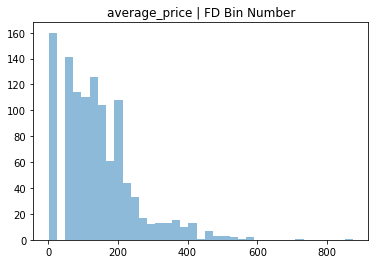

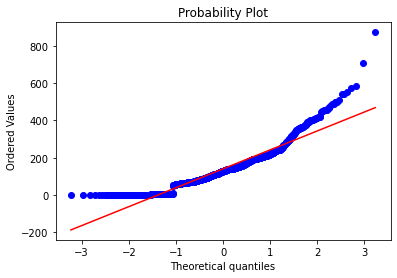

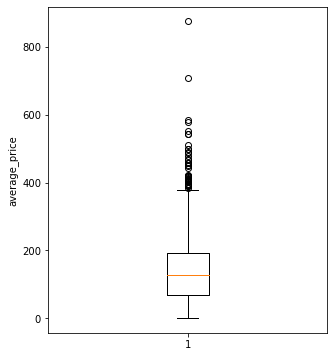

count    1115.000000
mean      140.623076
std       107.011544
min         1.300000
25%        70.000000
50%       128.000000
75%       193.000000
max       874.000000
Name: average_price, dtype: float64

In [8]:
plt.hist(bee.average_price, alpha = .5, bins = "fd")
plt.title("average_price | FD Bin Number")
plt.show()
stats.probplot(bee.average_price, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(bee.average_price)
plt.ylabel("average_price")
plt.show()
bee.average_price.describe()

The histogram is slightly skewed to the rightand it does not appear to be normally distributed. The QQ plot is close to being straight but it does curve upward indicating the average_price is not normally distributed. The box plot has some outliers above the upper extreme. The mean and median is relatively close to each other. The maximum is much larger than the 75% percentile. 

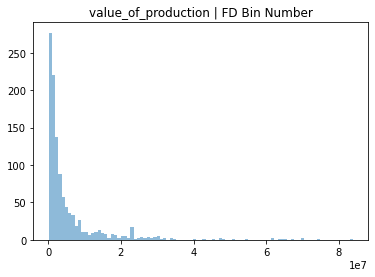

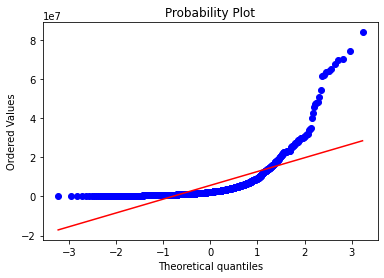

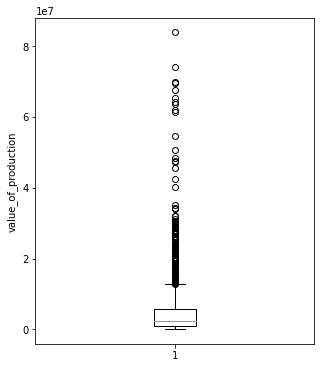

count    1.115000e+03
mean     5.667412e+06
std      9.459460e+06
min      1.060000e+05
25%      1.008000e+06
50%      2.281000e+06
75%      5.704000e+06
max      8.385900e+07
Name: value_of_production, dtype: float64

In [9]:
plt.hist(bee.value_of_production, alpha = .5, bins = "fd")
plt.title("value_of_production | FD Bin Number")
plt.show()
stats.probplot(bee.value_of_production, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(bee.value_of_production)
plt.ylabel("value_of_production")
plt.show()
bee.value_of_production.describe()

The histogram is heavily skewed to the right and does not show itself to be normally distributed. The QQ plot corroborates our hypothesis and value_of_production is not normally distributed. The box plot reveals a large amount of outliers above the upper extreme. The standard deviation is largger than the mean and the median. The median is smaller than the mean. The maximum is over 10 times larger than the mean and median. 

# 3

In [61]:
bee = bee.set_index(['state', 'year'], drop=False)


## Pooled

In [58]:
reg_ols = plm.PooledOLS.from_formula(
    formula='average_price ~ colonies_number + yield_per_colony + production + stocks +'
            'value_of_production + C(year)', data=bee)
results_ols = reg_ols.fit()

table_ols = pd.DataFrame({'b': round(results_ols.params, 4),
                          'se': round(results_ols.std_errors, 4),
                          't': round(results_ols.tstats, 4),
                          'pval': round(results_ols.pvalues, 4)})
print(f'table_ols: \n{table_ols}\n')

table_ols: 
                            b       se        t    pval
C(year)[T.1995]      145.4830  10.3748  14.0228  0.0000
C(year)[T.1996]      171.4121  10.4112  16.4642  0.0000
C(year)[T.1997]      166.3029  10.5286  15.7954  0.0000
C(year)[T.1998]      158.1044  10.5372  15.0044  0.0000
C(year)[T.1999]      153.7726  10.4199  14.7576  0.0000
C(year)[T.2000]      152.1526  10.4543  14.5541  0.0000
C(year)[T.2001]      160.4608  10.3595  15.4892  0.0000
C(year)[T.2002]      201.7183  10.1923  19.7913  0.0000
C(year)[T.2003]      212.8986   9.8387  21.6388  0.0000
C(year)[T.2004]      200.7494  10.3540  19.3885  0.0000
C(year)[T.2005]      185.7141  10.3387  17.9630  0.0000
C(year)[T.2006]      202.9383  10.2411  19.8162  0.0000
C(year)[T.2007]      207.4196  10.1543  20.4267  0.0000
C(year)[T.2008]      222.1917   9.9646  22.2981  0.0000
C(year)[T.2009]      234.5837   9.7406  24.0830  0.0000
C(year)[T.2010]      263.8518  10.1905  25.8920  0.0000
C(year)[T.2011]      285.1465  10.11

## Fixed Effects

In [83]:
# Both EntityEffects and TimeEffects
reg_fe = plm.PanelOLS.from_formula(
    formula='average_price ~ colonies_number + yield_per_colony + production + stocks +'
            'value_of_production + EntityEffects + TimeEffects', data=bee, drop_absorbed = True)
results_re = reg_fe.fit()

table_fe = pd.DataFrame({'b': round(results_fe.params, 4),
                         'se': round(results_fe.std_errors, 4),
                         't': round(results_fe.tstats, 4),
                         'pval': round(results_fe.pvalues, 4)})
print(f'table_fe: \n{table_fe}\n')

table_fe: 
                            b       se        t    pval
C(year)[T.1995]      145.4830  10.3748  14.0228  0.0000
C(year)[T.1996]      171.4121  10.4112  16.4642  0.0000
C(year)[T.1997]      166.3029  10.5286  15.7954  0.0000
C(year)[T.1998]      158.1044  10.5372  15.0044  0.0000
C(year)[T.1999]      153.7726  10.4199  14.7576  0.0000
C(year)[T.2000]      152.1526  10.4543  14.5541  0.0000
C(year)[T.2001]      160.4608  10.3595  15.4892  0.0000
C(year)[T.2002]      201.7183  10.1923  19.7913  0.0000
C(year)[T.2003]      212.8986   9.8387  21.6388  0.0000
C(year)[T.2004]      200.7494  10.3540  19.3885  0.0000
C(year)[T.2005]      185.7141  10.3387  17.9630  0.0000
C(year)[T.2006]      202.9383  10.2411  19.8162  0.0000
C(year)[T.2007]      207.4196  10.1543  20.4267  0.0000
C(year)[T.2008]      222.1917   9.9646  22.2981  0.0000
C(year)[T.2009]      234.5837   9.7406  24.0830  0.0000
C(year)[T.2010]      263.8518  10.1905  25.8920  0.0000
C(year)[T.2011]      285.1465  10.110

In [84]:
# EntityEffects
reg_fe = plm.PanelOLS.from_formula(
    formula='average_price ~ colonies_number + yield_per_colony + production + stocks +'
            'value_of_production + EntityEffects', data=bee)
results_re = reg_fe.fit()

table_fe = pd.DataFrame({'b': round(results_fe.params, 4),
                         'se': round(results_fe.std_errors, 4),
                         't': round(results_fe.tstats, 4),
                         'pval': round(results_fe.pvalues, 4)})
print(f'table_fe: \n{table_fe}\n')

table_fe: 
                            b       se        t    pval
C(year)[T.1995]      145.4830  10.3748  14.0228  0.0000
C(year)[T.1996]      171.4121  10.4112  16.4642  0.0000
C(year)[T.1997]      166.3029  10.5286  15.7954  0.0000
C(year)[T.1998]      158.1044  10.5372  15.0044  0.0000
C(year)[T.1999]      153.7726  10.4199  14.7576  0.0000
C(year)[T.2000]      152.1526  10.4543  14.5541  0.0000
C(year)[T.2001]      160.4608  10.3595  15.4892  0.0000
C(year)[T.2002]      201.7183  10.1923  19.7913  0.0000
C(year)[T.2003]      212.8986   9.8387  21.6388  0.0000
C(year)[T.2004]      200.7494  10.3540  19.3885  0.0000
C(year)[T.2005]      185.7141  10.3387  17.9630  0.0000
C(year)[T.2006]      202.9383  10.2411  19.8162  0.0000
C(year)[T.2007]      207.4196  10.1543  20.4267  0.0000
C(year)[T.2008]      222.1917   9.9646  22.2981  0.0000
C(year)[T.2009]      234.5837   9.7406  24.0830  0.0000
C(year)[T.2010]      263.8518  10.1905  25.8920  0.0000
C(year)[T.2011]      285.1465  10.110

In [85]:
# TimeEffects
reg_fe = plm.PanelOLS.from_formula(
    formula='average_price ~ colonies_number + yield_per_colony + production + stocks +'
            'value_of_production + TimeEffects', data=bee)
results_re = reg_fe.fit()

table_fe = pd.DataFrame({'b': round(results_fe.params, 4),
                         'se': round(results_fe.std_errors, 4),
                         't': round(results_fe.tstats, 4),
                         'pval': round(results_fe.pvalues, 4)})
print(f'table_fe: \n{table_fe}\n')

table_fe: 
                            b       se        t    pval
C(year)[T.1995]      145.4830  10.3748  14.0228  0.0000
C(year)[T.1996]      171.4121  10.4112  16.4642  0.0000
C(year)[T.1997]      166.3029  10.5286  15.7954  0.0000
C(year)[T.1998]      158.1044  10.5372  15.0044  0.0000
C(year)[T.1999]      153.7726  10.4199  14.7576  0.0000
C(year)[T.2000]      152.1526  10.4543  14.5541  0.0000
C(year)[T.2001]      160.4608  10.3595  15.4892  0.0000
C(year)[T.2002]      201.7183  10.1923  19.7913  0.0000
C(year)[T.2003]      212.8986   9.8387  21.6388  0.0000
C(year)[T.2004]      200.7494  10.3540  19.3885  0.0000
C(year)[T.2005]      185.7141  10.3387  17.9630  0.0000
C(year)[T.2006]      202.9383  10.2411  19.8162  0.0000
C(year)[T.2007]      207.4196  10.1543  20.4267  0.0000
C(year)[T.2008]      222.1917   9.9646  22.2981  0.0000
C(year)[T.2009]      234.5837   9.7406  24.0830  0.0000
C(year)[T.2010]      263.8518  10.1905  25.8920  0.0000
C(year)[T.2011]      285.1465  10.110

## Random Effects

In [86]:
reg_re = plm.RandomEffects.from_formula(
    formula='average_price ~ colonies_number + yield_per_colony + production + stocks +'
            'value_of_production + C(year)', data=bee)
results_re = reg_re.fit()

table_re = pd.DataFrame({'b': round(results_re.params, 4),
                         'se': round(results_re.std_errors, 4),
                         't': round(results_re.tstats, 4),
                         'pval': round(results_re.pvalues, 4)})
print(f'table_re: \n{table_re}\n')

table_re: 
                            b       se        t    pval
C(year)[T.1995]       97.2968  13.8248   7.0379  0.0000
C(year)[T.1996]      123.6005  13.8692   8.9119  0.0000
C(year)[T.1997]      117.6086  13.8950   8.4641  0.0000
C(year)[T.1998]      109.4004  13.9112   7.8642  0.0000
C(year)[T.1999]      105.6424  13.7148   7.7028  0.0000
C(year)[T.2000]      104.1729  13.7533   7.5744  0.0000
C(year)[T.2001]      113.4102  13.6246   8.3239  0.0000
C(year)[T.2002]      157.0481  13.5445  11.5950  0.0000
C(year)[T.2003]      172.6647  13.0422  13.2389  0.0000
C(year)[T.2004]      159.6794  13.3845  11.9302  0.0000
C(year)[T.2005]      142.5242  13.3828  10.6498  0.0000
C(year)[T.2006]      160.7832  13.2169  12.1649  0.0000
C(year)[T.2007]      165.9204  13.1133  12.6529  0.0000
C(year)[T.2008]      185.1501  12.8587  14.3988  0.0000
C(year)[T.2009]      199.0080  12.5602  15.8443  0.0000
C(year)[T.2010]      226.3436  12.9697  17.4518  0.0000
C(year)[T.2011]      249.0025  12.816

In [87]:
# Comparing the Models
theta_hat = results_re.theta.iloc[0, 0]
print(f'theta_hat: {theta_hat}\n')

print(f'table_ols: \n{table_ols}\n')

print(f'table_fe: \n{table_fe}\n')

print(f'table_re: \n{table_re}\n')

theta_hat: 0.8264371475149364

table_ols: 
                            b       se        t    pval
C(year)[T.1995]      145.4830  10.3748  14.0228  0.0000
C(year)[T.1996]      171.4121  10.4112  16.4642  0.0000
C(year)[T.1997]      166.3029  10.5286  15.7954  0.0000
C(year)[T.1998]      158.1044  10.5372  15.0044  0.0000
C(year)[T.1999]      153.7726  10.4199  14.7576  0.0000
C(year)[T.2000]      152.1526  10.4543  14.5541  0.0000
C(year)[T.2001]      160.4608  10.3595  15.4892  0.0000
C(year)[T.2002]      201.7183  10.1923  19.7913  0.0000
C(year)[T.2003]      212.8986   9.8387  21.6388  0.0000
C(year)[T.2004]      200.7494  10.3540  19.3885  0.0000
C(year)[T.2005]      185.7141  10.3387  17.9630  0.0000
C(year)[T.2006]      202.9383  10.2411  19.8162  0.0000
C(year)[T.2007]      207.4196  10.1543  20.4267  0.0000
C(year)[T.2008]      222.1917   9.9646  22.2981  0.0000
C(year)[T.2009]      234.5837   9.7406  24.0830  0.0000
C(year)[T.2010]      263.8518  10.1905  25.8920  0.0000
C(yea

In [88]:
b_fe = results_fe.params
b_fe_cov = results_fe.cov
b_re = results_re.params
b_re_cov = results_re.cov

# Hausman test of FE vs. RE
# (I) find overlapping coefficients:
common_coef = set(results_fe.params.index).intersection(results_re.params.index)

# (II) calculate differences between FE and RE:
b_diff = np.array(results_fe.params[common_coef] - results_re.params[common_coef])
df = len(b_diff)
b_diff.reshape((df, 1))
b_cov_diff = np.array(b_fe_cov.loc[common_coef, common_coef] -
                      b_re_cov.loc[common_coef, common_coef])
b_cov_diff.reshape((df, df))

# (III) calculate test statistic:
stat = abs(np.transpose(b_diff) @ np.linalg.inv(b_cov_diff) @ b_diff)
pval = 1 - stats.chi2.cdf(stat, df)

print(f'stat: {stat}\n')
print(f'pval: {pval}\n')
if pval < 0.05:
    print("Fail to reject the null hypothesis: the fixed effects model is the best")

stat: 106.64855783557437

pval: 5.86485415787763e-10

Fail to reject the null hypothesis: the fixed effects model is the best


## Conlcusion

In [82]:
# Both EntityEffects and TimeEffects
reg_fe = plm.PanelOLS.from_formula(
    formula='average_price ~ colonies_number + yield_per_colony + production + stocks +'
            'value_of_production + EntityEffects + TimeEffects', data=bee, drop_absorbed = True)
results_re = reg_fe.fit()

table_fe = pd.DataFrame({'b': round(results_fe.params, 4),
                         'se': round(results_fe.std_errors, 4),
                         't': round(results_fe.tstats, 4),
                         'pval': round(results_fe.pvalues, 4)})
print(f'table_fe: \n{table_fe}\n')

table_fe: 
                            b       se        t    pval
C(year)[T.1995]      145.4830  10.3748  14.0228  0.0000
C(year)[T.1996]      171.4121  10.4112  16.4642  0.0000
C(year)[T.1997]      166.3029  10.5286  15.7954  0.0000
C(year)[T.1998]      158.1044  10.5372  15.0044  0.0000
C(year)[T.1999]      153.7726  10.4199  14.7576  0.0000
C(year)[T.2000]      152.1526  10.4543  14.5541  0.0000
C(year)[T.2001]      160.4608  10.3595  15.4892  0.0000
C(year)[T.2002]      201.7183  10.1923  19.7913  0.0000
C(year)[T.2003]      212.8986   9.8387  21.6388  0.0000
C(year)[T.2004]      200.7494  10.3540  19.3885  0.0000
C(year)[T.2005]      185.7141  10.3387  17.9630  0.0000
C(year)[T.2006]      202.9383  10.2411  19.8162  0.0000
C(year)[T.2007]      207.4196  10.1543  20.4267  0.0000
C(year)[T.2008]      222.1917   9.9646  22.2981  0.0000
C(year)[T.2009]      234.5837   9.7406  24.0830  0.0000
C(year)[T.2010]      263.8518  10.1905  25.8920  0.0000
C(year)[T.2011]      285.1465  10.110

We will use the fixed effects model. Our theta is 0.82 which is somewhat close to 1; however, our Hausman-Test indicates that we should use the Fixed Effects model with the p-value close to 0. The number of colonies and yield per colony have negative effects on our average price of the honey. Stocks does not seem to affect average price, but its p-value is not statistically significant. Production and value of production do not affect our average price and are both statistically significant. 

# Part 2 | Qualitative Dependent Variable Models

# 1

In [96]:
diab = pd.read_csv("diabetes.csv")

**Pregnancies**: To express the Number of pregnancies **Glucose**: To express the Glucose level in blood **BloodPressure**: To express the Blood pressure measurement **SkinThickness**: To express the thickness of the skin **Insulin**: To express the Insulin level in blood **BMI**: To express the Body mass index **DiabetesPedigreeFunction**: To express the Diabetes percentage **Age**: To express the age **Outcome**: To express the final result 1 is Yes and 0 is No

Our second dataset is documenting potential identifiers and medical traits that signal diabetes in individuals. We wanted to take our hand at addressing a problem that is much more nuanced and with much higher consequences than our previous analyses which were mostly targeted at entrepreneurship. Furthermore, tackling medical prediction brings about a different type of caution when it comes to diagnosis accuracy that we thought might produce interesting results in a probability analysis such as Logit and Probit methods. In this dataset, we will attempt to produce a model that estimates the likelihood an individual has diabetes and also break down the consequences of our model and its accuracy in such a high stakes scenario. We don’t expect to produce a model that is ready for practical use– this field is already so widely studied and demanded because of the stakes. Instead, we hope to step outside our typical interests and comfort zone by tackling a problem with serious implications and interpretations.

In [97]:
diab.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


# 2

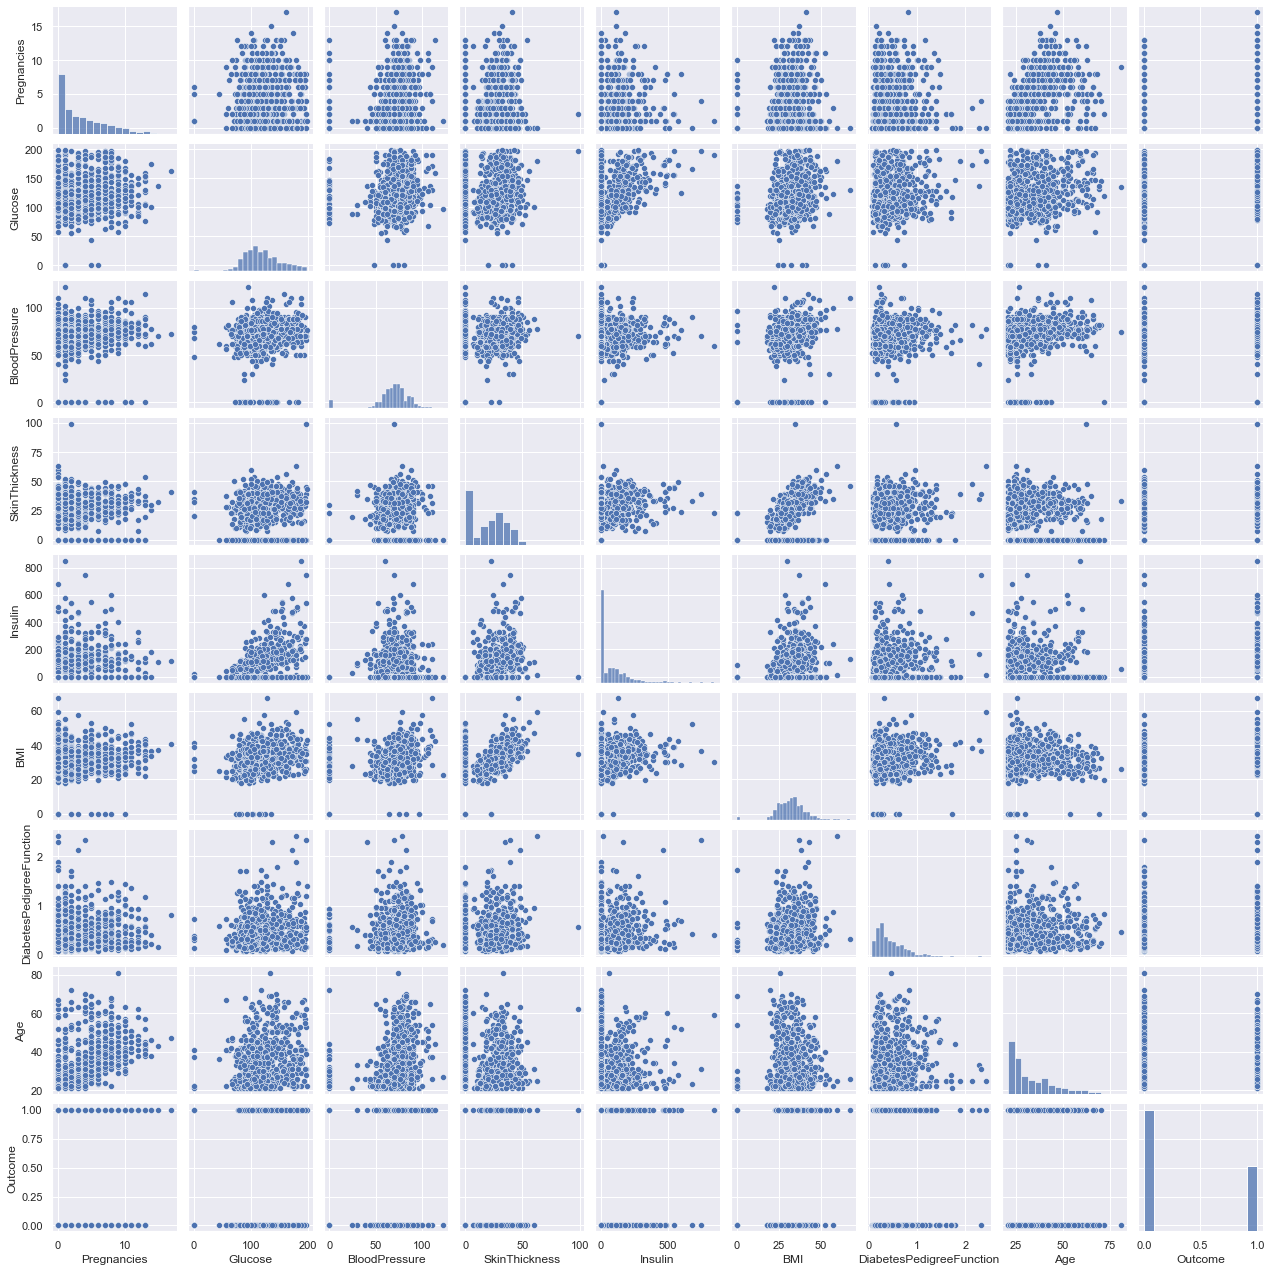

In [90]:
# Subsetting the data
subset = diab[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
                 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']]

# Creating a Pairplot for all of the quatitative variables 
sns.set()
sns.pairplot(subset, size = 2.0)
plt.show()

Our predictor varbiables do not have very strong trends between themselves. The predictor and outcome variables do have strong trends which is good.

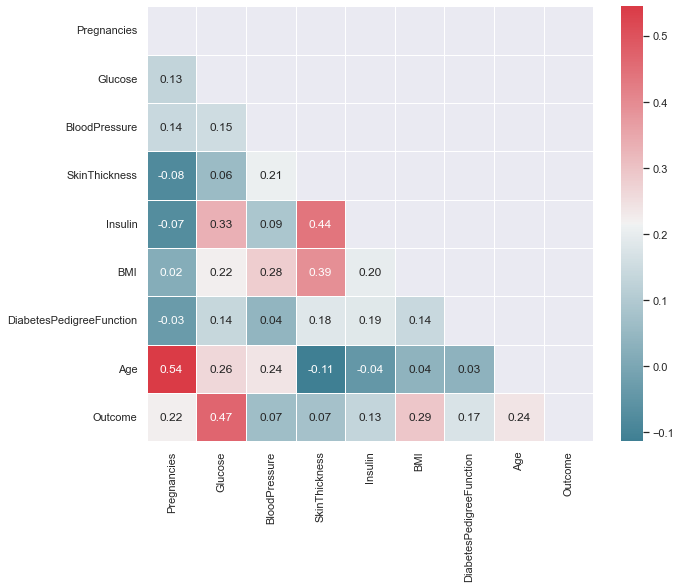

In [91]:
corr = diab.corr()
fig, ax = plt.subplots(figsize=(10, 8))
colormap = sns.diverging_palette(220, 10, as_cmap = True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True
sns.heatmap(corr, cmap = colormap, linewidths = .5, annot = True, fmt = ".2f", mask = dropvals)
plt.show()

The correlation plot shows us there is some correlation between variables. Overall, the multicollinearity among predictors is relatively low especially compared to the bee colony data. The highest is pregnancies and age, which makes perfect logical sense. Most relationships between predictors are not so high as to flag concern, but we can still look at some of the trends: one relationship is skin thickness and insulin, which may not be so obvious from a general knowledge perspective, which is one of the advantages of the correlation heatmap. For some of the other correlated variables like skin thickness and BMI and glucose and insulin, the relationship is easier to expect. 

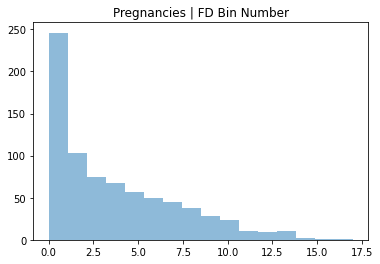

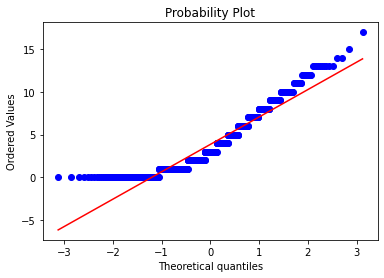

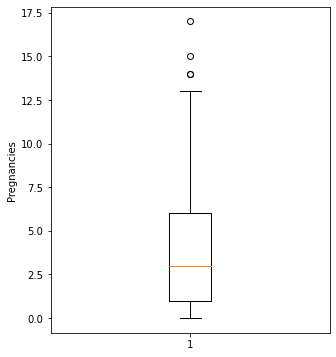

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       17.000000
Name: Pregnancies, dtype: float64

In [15]:
plt.hist(diab.Pregnancies, alpha = .5, bins = "fd")
plt.title("Pregnancies | FD Bin Number")
plt.show()
stats.probplot(diab.Pregnancies, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(diab.Pregnancies)
plt.ylabel("Pregnancies")
plt.show()
diab.Pregnancies.describe()

Our histogram for the pregnancy variable shows an extreme right skew for the distribution. Furthermore, the probability plot features some abnormalities such as the plateau early on in the graph that provides more evidence that the distribution is not normal. The boxplot shows some outliers and implies the same skew with a extremely large fourth quartile compared to the other quartile ranges.

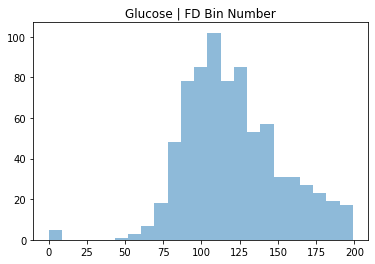

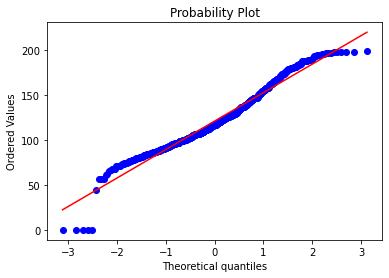

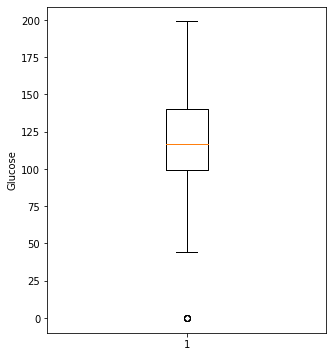

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
25%       99.000000
50%      117.000000
75%      140.250000
max      199.000000
Name: Glucose, dtype: float64

In [16]:
plt.hist(diab.Glucose, alpha = .5, bins = "fd")
plt.title("Glucose | FD Bin Number")
plt.show()
stats.probplot(diab.Glucose, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(diab.Glucose)
plt.ylabel("Glucose")
plt.show()
diab.Glucose.describe()

The histogram for the glucose variable is much more normal than other variables we’ve described, with a clear center and slight right skew. The QQ probability plot provides further evidence for normality with a large amount of the data hugging the linear expectation for a normal distribution, although with falloff towards the extremes. The boxplot also shows a relatively normal distribution with the quartile ranges looking relatively balanced, with minimal outliers other than the data point at zero.

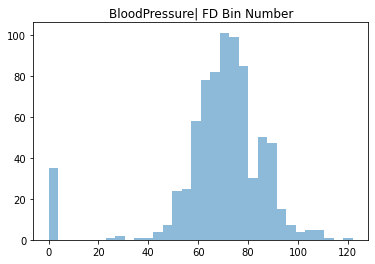

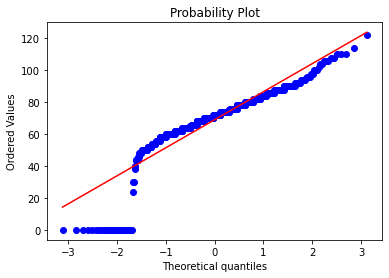

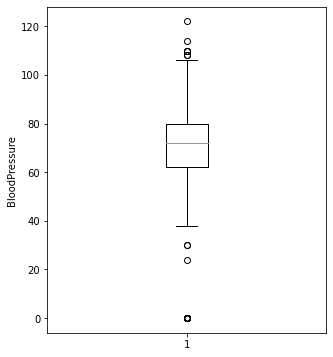

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
25%       62.000000
50%       72.000000
75%       80.000000
max      122.000000
Name: BloodPressure, dtype: float64

In [17]:
plt.hist(diab.BloodPressure, alpha = .5, bins = "fd")
plt.title("BloodPressure| FD Bin Number")
plt.show()
stats.probplot(diab.BloodPressure, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(diab.BloodPressure)
plt.ylabel("BloodPressure")
plt.show()
diab.BloodPressure.describe()

Blood pressure also has a more normal appearing distribution based on the histogram, except for an independent cluster of data points near zero. Excluding this abnormal feature, the data is actually decently normal with little no skew in either direction. The QQ probability plot is greatly affected by the cluster at zero, with the values dropping off suddenly from the expected linear shape. The boxplot appears fairly normal, but upon closer inspection we can tell that the outlier near zero is actually that irregular data appearance, it just is difficult to distinguish as a huge cluster rather than an individual point without additional visualization tools.

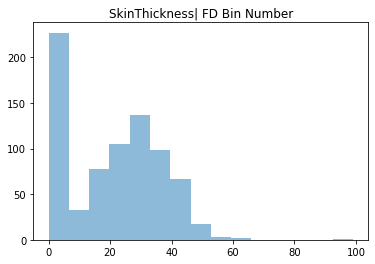

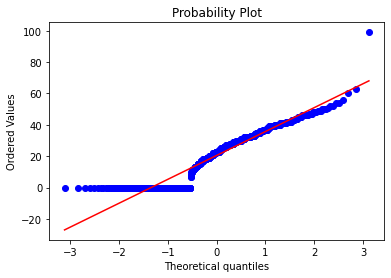

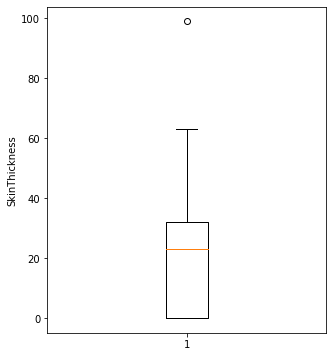

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
25%        0.000000
50%       23.000000
75%       32.000000
max       99.000000
Name: SkinThickness, dtype: float64

In [18]:
plt.hist(diab.SkinThickness, alpha = .5, bins = "fd")
plt.title("SkinThickness| FD Bin Number")
plt.show()
stats.probplot(diab.SkinThickness, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(diab.SkinThickness)
plt.ylabel("SkinThickness")
plt.show()
diab.SkinThickness.describe()

Skin Thickness is definitely a weird one in comparison to the other variables in the set. There is a high concentration of data point at or near zero and then a much smaller distribution that appears somewhat normal with a right skew. What makes this one more notable is that the normal appearing section of the data is so small compared to the cluster at zero. On the QQ probability plot, almost half the plot falls under that bin near zero, although the other section is fairly linear on the QQ plot, indicating normality for that range. Similarly, on the box plot there is no whisker for the lowest quartile at all, with so much of the data falling within the same range portrayed by the box.

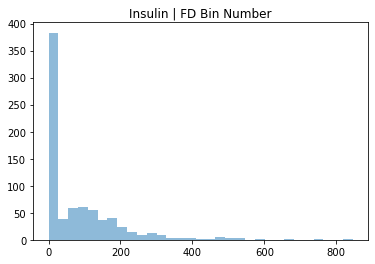

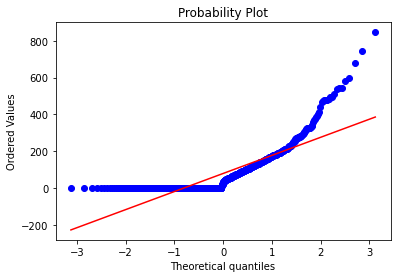

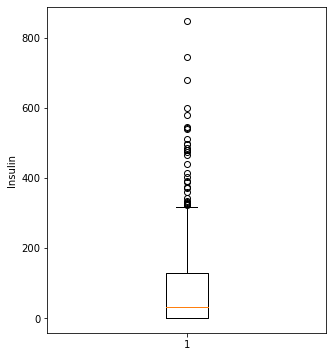

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
25%        0.000000
50%       30.500000
75%      127.250000
max      846.000000
Name: Insulin, dtype: float64

In [19]:
plt.hist(diab.Insulin, alpha = .5, bins = "fd")
plt.title("Insulin | FD Bin Number")
plt.show()
stats.probplot(diab.Insulin, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(diab.Insulin)
plt.ylabel("Insulin")
plt.show()
diab.Insulin.describe()

It’s hard to tell with insulin whether it is just a very extreme right skew or if it is like skin thickness in that it is a large bin at zero and then a much smaller normal section of the data. Either way, referencing the QQ probability plot the data is a far departure from normal, with little of the data falling in the linear pattern we would expect. There is a sharp plateau early in the data and then later on in the plot the data trails off to an extreme. On the boxplot, the middle quartile ranges are extremely compressed

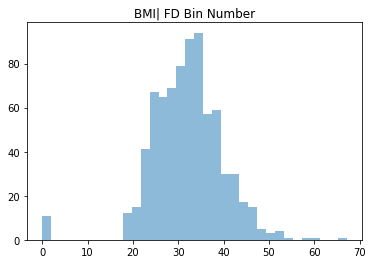

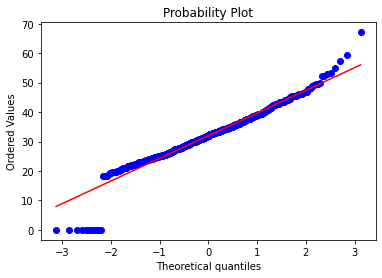

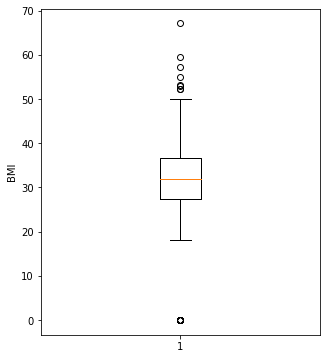

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

In [20]:
plt.hist(diab.BMI, alpha = .5, bins = "fd")
plt.title("BMI| FD Bin Number")
plt.show()
stats.probplot(diab.BMI, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(diab.BMI)
plt.ylabel("BMI")
plt.show()
diab.BMI.describe()

BMI looks fairly normal based on the histogram. We get the same cluster at zero as the other variables just because of the nature of the data, but it’s much, much smaller here which emphasizes the normality of the main data distribution. The QQ probability plot again has some deviation at the extremes but for the most part the body of the data follows the linear pattern expected from a normal distribution. The boxplot had some slight unbalance towards the fourth quartile whisker and some outlier presence on both ends, both overall is acceptable.

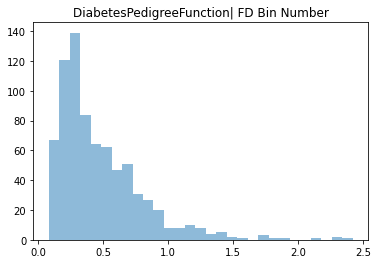

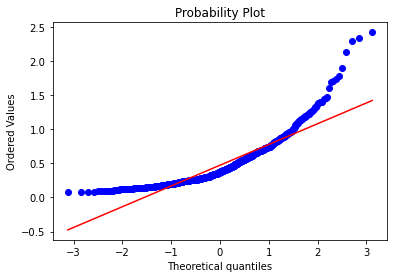

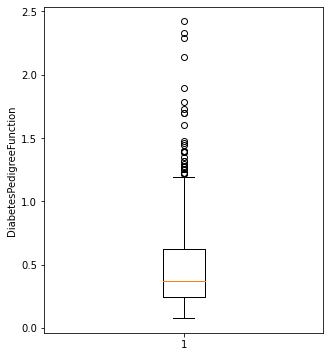

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64

In [21]:
plt.hist(diab.DiabetesPedigreeFunction, alpha = .5, bins = "fd")
plt.title("DiabetesPedigreeFunction| FD Bin Number")
plt.show()
stats.probplot(diab.DiabetesPedigreeFunction, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(diab.DiabetesPedigreeFunction)
plt.ylabel("DiabetesPedigreeFunction")
plt.show()
diab.DiabetesPedigreeFunction.describe()

Diabetes pedigree function has a large right skew and does not appear normal. On the QQ probability plot, we can see that the right skew actually follows a consistent distribution which makes it prime candidate for transformation depending on the analysis performed, but as it is now, it is definitely not normal and has higher concentration of values at each extreme. The boxplot has a heavy presence of outliers for high values and a long fourth quartile as we would expect due to the right skew.

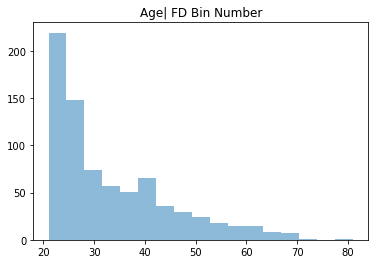

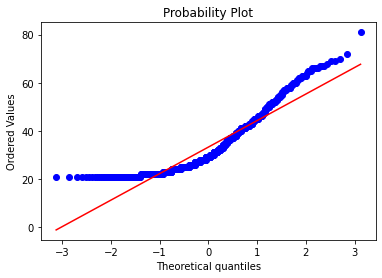

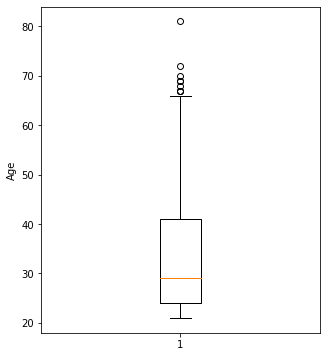

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
25%       24.000000
50%       29.000000
75%       41.000000
max       81.000000
Name: Age, dtype: float64

In [22]:
plt.hist(diab.Age, alpha = .5, bins = "fd")
plt.title("Age| FD Bin Number")
plt.show()
stats.probplot(diab.Age, dist = "norm", plot = plt)
plt.show()
plt.figure(figsize=(5,6))
plt.boxplot(diab.Age)
plt.ylabel("Age")
plt.show()
diab.Age.describe()

For age, we see a true heavy right skew distribution. The survey respondents were largely in their early twenties with the data consistently tapering off as age increased. This skew is also reflected in the QQ probability plot with a plateau of data nearing 20, and the other data does deviate slightly for higher ages as well and so does not fit the pattern we would expect from a normal distribution. The boxplot reflects the skew similarly with a long fourth quartile whisker and a longer third quartile compared to the second as well. All the outliers are present at the end of the data range, further indicating the variable is not normal and has extreme skew.

# 3

In [24]:
# Linear
result_lin = smf.ols(formula='Outcome ~ Pregnancies + Glucose + BloodPressure +'
                          'SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age',
                  data=diab).fit(cov_type='HC3')
# Probit
result_probit = smf.probit(formula='Outcome ~ Pregnancies + Glucose + BloodPressure +'
                          'SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age',
                        data=diab).fit(disp=0)

# Logit
result_logit = smf.logit(formula='Outcome ~ Pregnancies + Glucose + BloodPressure +'
                          'SkinThickness + Insulin + BMI + DiabetesPedigreeFunction + Age',
                      data=diab).fit(disp=0)

In [25]:
result_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     52.04
Date:                Fri, 02 Dec 2022   Prob (F-statistic):           3.54e-67
Time:                        15:34:15   Log-Likelihood:                -381.91
No. Observations:                 768   AIC:                             781.8
Df Residuals:                     759   BIC:                             823.6
Df Model:                           8                                         
Covariance Type:                  HC3                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.8539      0.078    -10.971      0.000      -1.006      -0.701
Pregnancies                  0.0206      0.006      3.556      0.000       0.009       0.032
Glucose                      0.0059      0.001     10.033      0.000       0.005       0.007
BloodPressure               -0.0023      0.001     -2.925      0.003      -0.004      -0.001
SkinThickness                0.0002      0.001      0.134      0.894      -0.002       0.002
Insulin                     -0.0002      0.000     -1.024      0.306      -0.001       0.000
BMI                          0.0132      0.002      6.086      0.000       0.009       0.018
DiabetesPedigreeFunction     0.1472      0.052      2.851      0.004       0.046       0.248
Age                          0.0026      0.002      1.477      0.140      -0.001       0.006
==============================================================================
Omnibus:                       41.539   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.183
Skew:                           0.395   Prob(JB):                     1.69e-07
Kurtosis:                       2.408   Cond. No.                     1.10e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
result_probit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  768
Model:                         Probit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Fri, 02 Dec 2022   Pseudo R-squ.:                  0.2697
Time:                        15:34:15   Log-Likelihood:                -362.79
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 2.736e-53
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -4.8638      0.384    -12.653      0.000      -5.617      -4.110
Pregnancies                  0.0723      0.018      3.972      0.000       0.037       0.108
Glucose                      0.0199      0.002      9.968      0.000       0.016       0.024
BloodPressure               -0.0079      0.003     -2.585      0.010      -0.014      -0.002
SkinThickness                0.0012      0.004      0.307      0.758      -0.007       0.009
Insulin                     -0.0007      0.001     -1.423      0.155      -0.002       0.000
BMI                          0.0523      0.008      6.250      0.000       0.036       0.069
DiabetesPedigreeFunction     0.4982      0.164      3.036      0.002       0.177       0.820
Age                          0.0102      0.005      1.887      0.059      -0.000       0.021
============================================================================================
"""

In [27]:
result_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Fri, 02 Dec 2022   Pseudo R-squ.:                  0.2718
Time:                        15:34:15   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -8.4047      0.717    -11.728      0.000      -9.809      -7.000
Pregnancies                  0.1232      0.032      3.840      0.000       0.060       0.186
Glucose                      0.0352      0.004      9.481      0.000       0.028       0.042
BloodPressure               -0.0133      0.005     -2.540      0.011      -0.024      -0.003
SkinThickness                0.0006      0.007      0.090      0.929      -0.013       0.014
Insulin                     -0.0012      0.001     -1.322      0.186      -0.003       0.001
BMI                          0.0897      0.015      5.945      0.000       0.060       0.119
DiabetesPedigreeFunction     0.9452      0.299      3.160      0.002       0.359       1.531
Age                          0.0149      0.009      1.593      0.111      -0.003       0.033
============================================================================================
"""

In [28]:
APE_lin = np.array(result_lin.params)

xb_logit = result_logit.fittedvalues
factor_logit = np.mean(stats.logistic.pdf(xb_logit))
APE_logit_manual = result_logit.params * factor_logit

xb_probit = result_probit.fittedvalues
factor_probit = np.mean(stats.norm.pdf(xb_probit))
APE_probit_manual = result_probit.params * factor_probit

table_manual = pd.DataFrame({'APE_lin': np.round(APE_lin, 4),
                             'APE_logit_manual': np.round(APE_logit_manual, 4),
                             'APE_probit_manual': np.round(APE_probit_manual, 4)})
print(f'table_manual: \n{table_manual}\n')

table_manual: 
                          APE_lin  APE_logit_manual  APE_probit_manual
Intercept                 -0.8539           -1.2907            -1.2970
Pregnancies                0.0206            0.0189             0.0193
Glucose                    0.0059            0.0054             0.0053
BloodPressure             -0.0023           -0.0020            -0.0021
SkinThickness              0.0002            0.0001             0.0003
Insulin                   -0.0002           -0.0002            -0.0002
BMI                        0.0132            0.0138             0.0140
DiabetesPedigreeFunction   0.1472            0.1451             0.1329
Age                        0.0026            0.0023             0.0027



All of the coefficients are relatively close and have the same signs. Logit and Probit are more similar. Increased blood pressure and insulin decreases the probability of having diabetes on average. All other coefficients increase the probability of having diabetes on average.

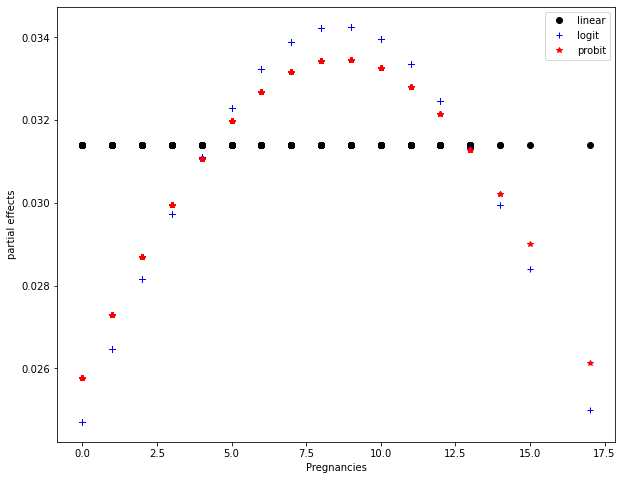

In [34]:
# estimation:
reg_lin = smf.ols(formula='Outcome ~ Pregnancies', data=diab)
results_lin = reg_lin.fit()
reg_logit = smf.logit(formula='Outcome ~ Pregnancies', data=diab)
results_logit = reg_logit.fit(disp=0)
reg_probit = smf.probit(formula='Outcome ~ Pregnancies', data=diab)
results_probit = reg_probit.fit(disp=0)

# calculate partial effects:
PE_lin = np.repeat(results_lin.params['Pregnancies'], 768)

xb_logit = results_logit.fittedvalues
factor_logit = stats.logistic.pdf(xb_logit)
PE_logit = results_logit.params['Pregnancies'] * factor_logit

xb_probit = results_probit.fittedvalues
factor_probit = stats.norm.pdf(xb_probit)
PE_probit = results_probit.params['Pregnancies'] * factor_probit


# plot APE's:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(diab['Pregnancies'], PE_lin, color='black',
         marker='o', linestyle='', label='linear')
plt.plot(diab['Pregnancies'], PE_logit, color='blue',
         marker='+', linestyle='', label='logit')
plt.plot(diab['Pregnancies'], PE_probit, color='red',
         marker='*', linestyle='', label='probit')
plt.ylabel('partial effects')
plt.xlabel('Pregnancies')
plt.legend()

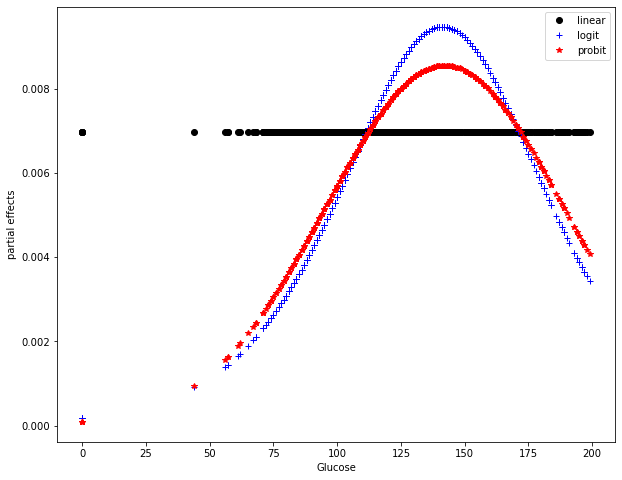

In [35]:
# estimation:
reg_lin = smf.ols(formula='Outcome ~ Glucose', data=diab)
results_lin = reg_lin.fit()
reg_logit = smf.logit(formula='Outcome ~ Glucose', data=diab)
results_logit = reg_logit.fit(disp=0)
reg_probit = smf.probit(formula='Outcome ~ Glucose', data=diab)
results_probit = reg_probit.fit(disp=0)

# calculate partial effects:
PE_lin = np.repeat(results_lin.params['Glucose'], 768)

xb_logit = results_logit.fittedvalues
factor_logit = stats.logistic.pdf(xb_logit)
PE_logit = results_logit.params['Glucose'] * factor_logit

xb_probit = results_probit.fittedvalues
factor_probit = stats.norm.pdf(xb_probit)
PE_probit = results_probit.params['Glucose'] * factor_probit


# plot APE's:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(diab['Glucose'], PE_lin, color='black',
         marker='o', linestyle='', label='linear')
plt.plot(diab['Glucose'], PE_logit, color='blue',
         marker='+', linestyle='', label='logit')
plt.plot(diab['Glucose'], PE_probit, color='red',
         marker='*', linestyle='', label='probit')
plt.ylabel('partial effects')
plt.xlabel('Glucose')
plt.legend()

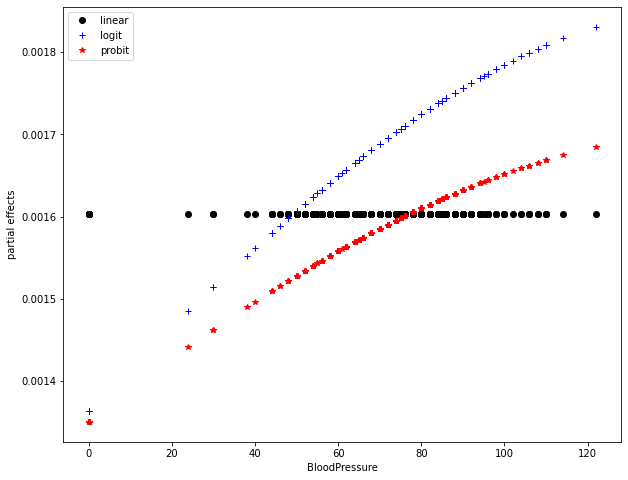

In [36]:
# estimation:
reg_lin = smf.ols(formula='Outcome ~ BloodPressure', data=diab)
results_lin = reg_lin.fit()
reg_logit = smf.logit(formula='Outcome ~ BloodPressure', data=diab)
results_logit = reg_logit.fit(disp=0)
reg_probit = smf.probit(formula='Outcome ~ BloodPressure', data=diab)
results_probit = reg_probit.fit(disp=0)

# calculate partial effects:
PE_lin = np.repeat(results_lin.params['BloodPressure'], 768)

xb_logit = results_logit.fittedvalues
factor_logit = stats.logistic.pdf(xb_logit)
PE_logit = results_logit.params['BloodPressure'] * factor_logit

xb_probit = results_probit.fittedvalues
factor_probit = stats.norm.pdf(xb_probit)
PE_probit = results_probit.params['BloodPressure'] * factor_probit


# plot APE's:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(diab['BloodPressure'], PE_lin, color='black',
         marker='o', linestyle='', label='linear')
plt.plot(diab['BloodPressure'], PE_logit, color='blue',
         marker='+', linestyle='', label='logit')
plt.plot(diab['BloodPressure'], PE_probit, color='red',
         marker='*', linestyle='', label='probit')
plt.ylabel('partial effects')
plt.xlabel('BloodPressure')
plt.legend()

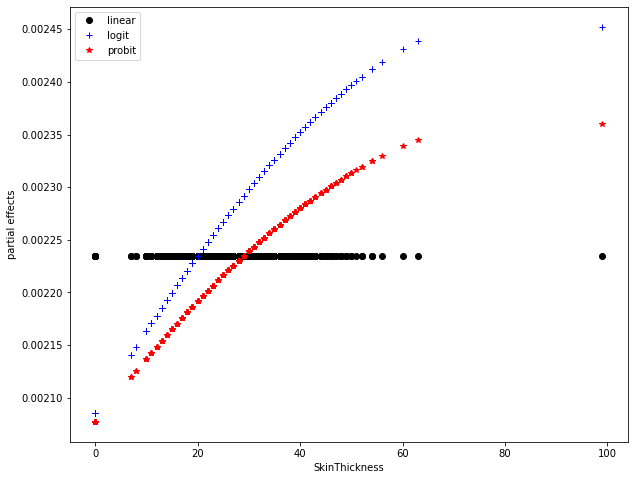

In [37]:
# estimation:
reg_lin = smf.ols(formula='Outcome ~ SkinThickness', data=diab)
results_lin = reg_lin.fit()
reg_logit = smf.logit(formula='Outcome ~ SkinThickness', data=diab)
results_logit = reg_logit.fit(disp=0)
reg_probit = smf.probit(formula='Outcome ~ SkinThickness', data=diab)
results_probit = reg_probit.fit(disp=0)

# calculate partial effects:
PE_lin = np.repeat(results_lin.params['SkinThickness'], 768)

xb_logit = results_logit.fittedvalues
factor_logit = stats.logistic.pdf(xb_logit)
PE_logit = results_logit.params['SkinThickness'] * factor_logit

xb_probit = results_probit.fittedvalues
factor_probit = stats.norm.pdf(xb_probit)
PE_probit = results_probit.params['SkinThickness'] * factor_probit


# plot APE's:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(diab['SkinThickness'], PE_lin, color='black',
         marker='o', linestyle='', label='linear')
plt.plot(diab['SkinThickness'], PE_logit, color='blue',
         marker='+', linestyle='', label='logit')
plt.plot(diab['SkinThickness'], PE_probit, color='red',
         marker='*', linestyle='', label='probit')
plt.ylabel('partial effects')
plt.xlabel('SkinThickness')
plt.legend()

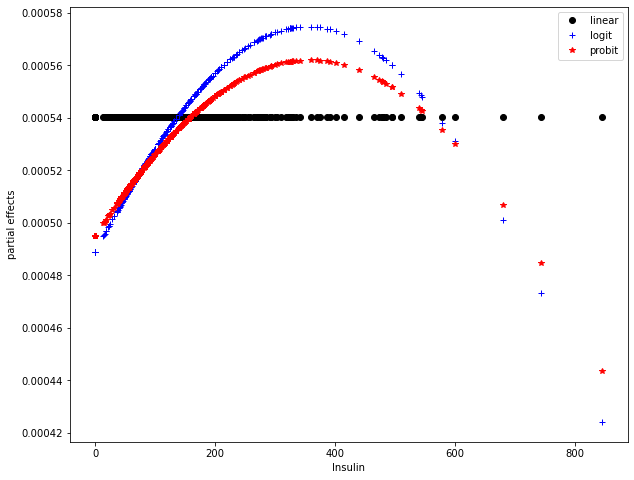

In [38]:
# estimation:
reg_lin = smf.ols(formula='Outcome ~ Insulin', data=diab)
results_lin = reg_lin.fit()
reg_logit = smf.logit(formula='Outcome ~ Insulin', data=diab)
results_logit = reg_logit.fit(disp=0)
reg_probit = smf.probit(formula='Outcome ~ Insulin', data=diab)
results_probit = reg_probit.fit(disp=0)

# calculate partial effects:
PE_lin = np.repeat(results_lin.params['Insulin'], 768)

xb_logit = results_logit.fittedvalues
factor_logit = stats.logistic.pdf(xb_logit)
PE_logit = results_logit.params['Insulin'] * factor_logit

xb_probit = results_probit.fittedvalues
factor_probit = stats.norm.pdf(xb_probit)
PE_probit = results_probit.params['Insulin'] * factor_probit


# plot APE's:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(diab['Insulin'], PE_lin, color='black',
         marker='o', linestyle='', label='linear')
plt.plot(diab['Insulin'], PE_logit, color='blue',
         marker='+', linestyle='', label='logit')
plt.plot(diab['Insulin'], PE_probit, color='red',
         marker='*', linestyle='', label='probit')
plt.ylabel('partial effects')
plt.xlabel('Insulin')
plt.legend()

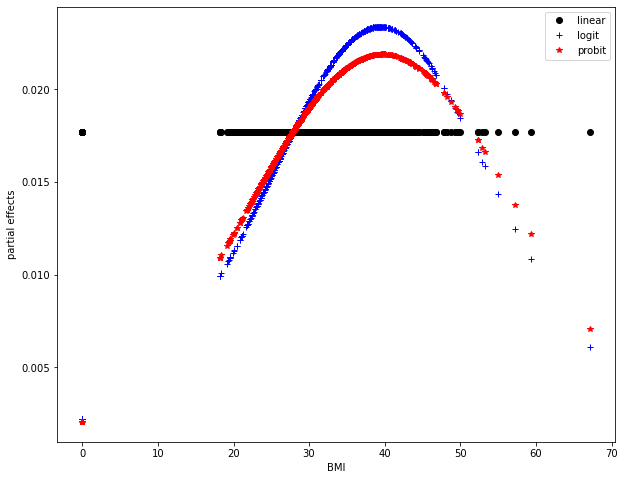

In [39]:
# estimation:
reg_lin = smf.ols(formula='Outcome ~ BMI', data=diab)
results_lin = reg_lin.fit()
reg_logit = smf.logit(formula='Outcome ~ BMI', data=diab)
results_logit = reg_logit.fit(disp=0)
reg_probit = smf.probit(formula='Outcome ~ BMI', data=diab)
results_probit = reg_probit.fit(disp=0)

# calculate partial effects:
PE_lin = np.repeat(results_lin.params['BMI'], 768)

xb_logit = results_logit.fittedvalues
factor_logit = stats.logistic.pdf(xb_logit)
PE_logit = results_logit.params['BMI'] * factor_logit

xb_probit = results_probit.fittedvalues
factor_probit = stats.norm.pdf(xb_probit)
PE_probit = results_probit.params['BMI'] * factor_probit


# plot APE's:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(diab['BMI'], PE_lin, color='black',
         marker='o', linestyle='', label='linear')
plt.plot(diab['BMI'], PE_logit, color='blue',
         marker='+', linestyle='', label='logit')
plt.plot(diab['BMI'], PE_probit, color='red',
         marker='*', linestyle='', label='probit')
plt.ylabel('partial effects')
plt.xlabel('BMI')
plt.legend()

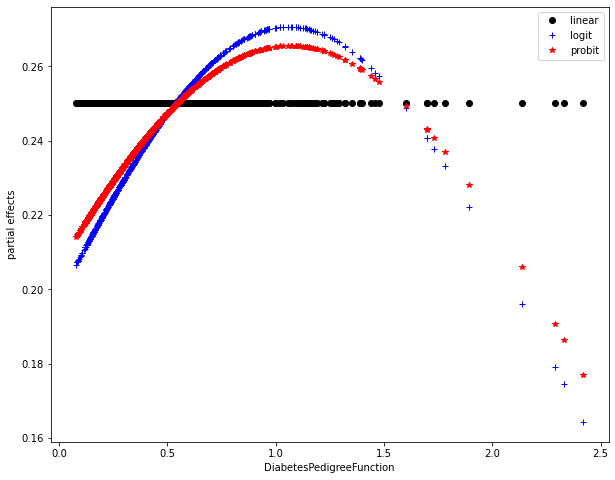

In [40]:
# estimation:
reg_lin = smf.ols(formula='Outcome ~ DiabetesPedigreeFunction', data=diab)
results_lin = reg_lin.fit()
reg_logit = smf.logit(formula='Outcome ~ DiabetesPedigreeFunction', data=diab)
results_logit = reg_logit.fit(disp=0)
reg_probit = smf.probit(formula='Outcome ~ DiabetesPedigreeFunction', data=diab)
results_probit = reg_probit.fit(disp=0)

# calculate partial effects:
PE_lin = np.repeat(results_lin.params['DiabetesPedigreeFunction'], 768)

xb_logit = results_logit.fittedvalues
factor_logit = stats.logistic.pdf(xb_logit)
PE_logit = results_logit.params['DiabetesPedigreeFunction'] * factor_logit

xb_probit = results_probit.fittedvalues
factor_probit = stats.norm.pdf(xb_probit)
PE_probit = results_probit.params['DiabetesPedigreeFunction'] * factor_probit


# plot APE's:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(diab['DiabetesPedigreeFunction'], PE_lin, color='black',
         marker='o', linestyle='', label='linear')
plt.plot(diab['DiabetesPedigreeFunction'], PE_logit, color='blue',
         marker='+', linestyle='', label='logit')
plt.plot(diab['DiabetesPedigreeFunction'], PE_probit, color='red',
         marker='*', linestyle='', label='probit')
plt.ylabel('partial effects')
plt.xlabel('DiabetesPedigreeFunction')
plt.legend()

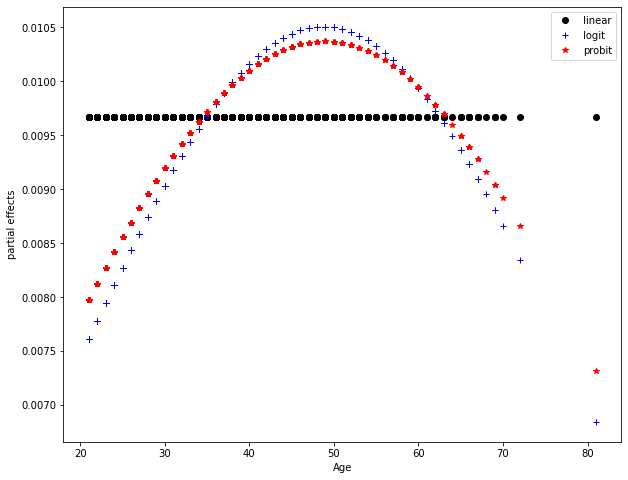

In [41]:
# estimation:
reg_lin = smf.ols(formula='Outcome ~ Age', data=diab)
results_lin = reg_lin.fit()
reg_logit = smf.logit(formula='Outcome ~ Age', data=diab)
results_logit = reg_logit.fit(disp=0)
reg_probit = smf.probit(formula='Outcome ~ Age', data=diab)
results_probit = reg_probit.fit(disp=0)

# calculate partial effects:
PE_lin = np.repeat(results_lin.params['Age'], 768)

xb_logit = results_logit.fittedvalues
factor_logit = stats.logistic.pdf(xb_logit)
PE_logit = results_logit.params['Age'] * factor_logit

xb_probit = results_probit.fittedvalues
factor_probit = stats.norm.pdf(xb_probit)
PE_probit = results_probit.params['Age'] * factor_probit


# plot APE's:
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(diab['Age'], PE_lin, color='black',
         marker='o', linestyle='', label='linear')
plt.plot(diab['Age'], PE_logit, color='blue',
         marker='+', linestyle='', label='logit')
plt.plot(diab['Age'], PE_probit, color='red',
         marker='*', linestyle='', label='probit')
plt.ylabel('partial effects')
plt.xlabel('Age')
plt.legend()

In [106]:
Pregnancies = np.linspace(diab['Pregnancies'].min(), diab['Pregnancies'].max(), 50)
Glucose = np.linspace(diab['Glucose'].min(), diab['Glucose'].max(), 50)
BloodPressure = np.linspace(diab['BloodPressure'].min(), diab['BloodPressure'].max(), 50)
SkinThickness = np.linspace(diab['SkinThickness'].min(), diab['SkinThickness'].max(), 50)
Insulin = np.linspace(diab['Insulin'].min(), diab['Insulin'].max(), 50)
BMI = np.linspace(diab['BMI'].min(), diab['BMI'].max(), 50)
DiabetesPedigreeFunction = np.linspace(diab['DiabetesPedigreeFunction'].min(), diab['DiabetesPedigreeFunction'].max(), 50)
Age = np.linspace(diab['Age'].min(), diab['Age'].max(), 50)

X_new = pd.DataFrame(
            {'Pregnancies': Pregnancies,
             'Glucose': Glucose, 'BloodPressure': BloodPressure,
             'SkinThickness': SkinThickness, 'Insulin': Insulin,
             'BMI' : BMI, 'DiabetesPedigreeFunction' : DiabetesPedigreeFunction,
             'Age' : Age})

X_new.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
1,0.346939,4.061224,2.489796,2.020408,17.265306,1.369388,0.125796,22.224490
2,0.693878,8.122449,4.979592,4.040816,34.530612,2.738776,0.173592,23.448980
3,1.040816,12.183673,7.469388,6.061224,51.795918,4.108163,0.221388,24.673469
4,1.387755,16.244898,9.959184,8.081633,69.061224,5.477551,0.269184,25.897959


In [107]:
predictions_lin = result_lin.predict(X_new)
predictions_logit = result_logit.predict(X_new)
predictions_probit = result_probit.predict(X_new)

y = diab['Outcome']

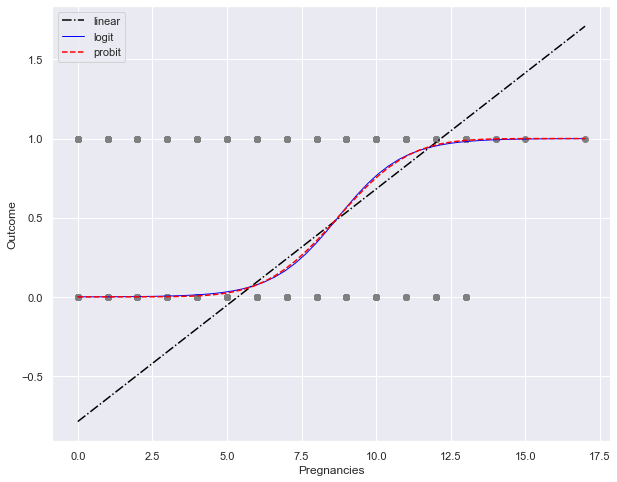

In [108]:
xPregnancies = diab['Pregnancies']

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(xPregnancies, y, color='grey', marker='o', linestyle='')
plt.plot(X_new['Pregnancies'], predictions_lin,
         color='black', linestyle='-.', label='linear')
plt.plot(X_new['Pregnancies'], predictions_logit,
         color='blue', linestyle='-', linewidth=1, label='logit')
plt.plot(X_new['Pregnancies'], predictions_probit,
         color='red', linestyle='--', label='probit')
plt.ylabel('Outcome')
plt.xlabel('Pregnancies')
plt.legend()

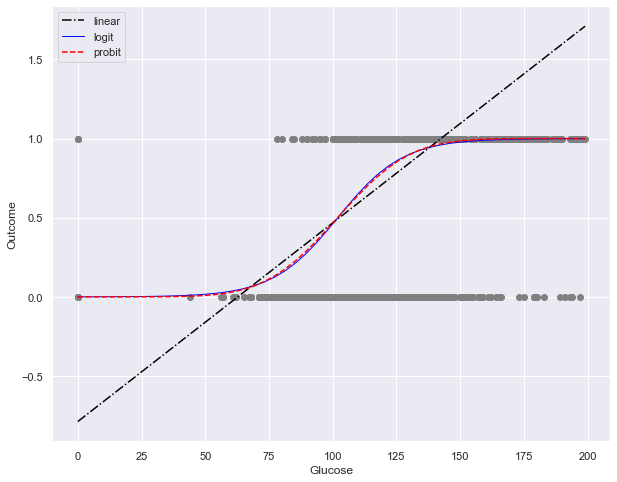

In [109]:
xGlucose = diab['Glucose']

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(xGlucose, y, color='grey', marker='o', linestyle='')
plt.plot(X_new['Glucose'], predictions_lin,
         color='black', linestyle='-.', label='linear')
plt.plot(X_new['Glucose'], predictions_logit,
         color='blue', linestyle='-', linewidth=1, label='logit')
plt.plot(X_new['Glucose'], predictions_probit,
         color='red', linestyle='--', label='probit')
plt.ylabel('Outcome')
plt.xlabel('Glucose')
plt.legend()

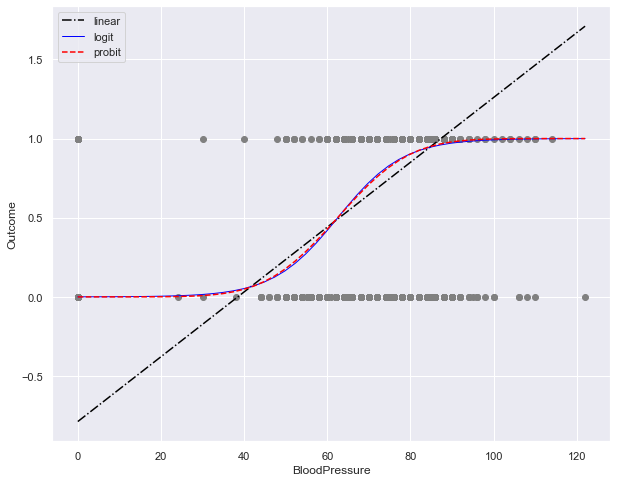

In [110]:
xBloodPressure = diab['BloodPressure']

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(xBloodPressure, y, color='grey', marker='o', linestyle='')
plt.plot(X_new['BloodPressure'], predictions_lin,
         color='black', linestyle='-.', label='linear')
plt.plot(X_new['BloodPressure'], predictions_logit,
         color='blue', linestyle='-', linewidth=1, label='logit')
plt.plot(X_new['BloodPressure'], predictions_probit,
         color='red', linestyle='--', label='probit')
plt.ylabel('Outcome')
plt.xlabel('BloodPressure')
plt.legend()

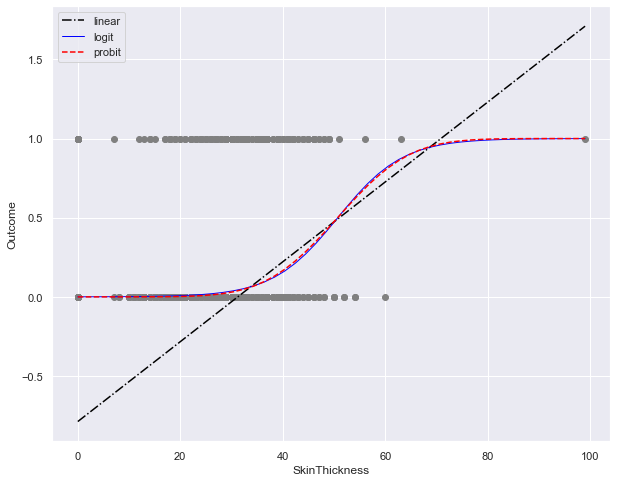

In [111]:
xSkinThickness = diab['SkinThickness']

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(xSkinThickness, y, color='grey', marker='o', linestyle='')
plt.plot(X_new['SkinThickness'], predictions_lin,
         color='black', linestyle='-.', label='linear')
plt.plot(X_new['SkinThickness'], predictions_logit,
         color='blue', linestyle='-', linewidth=1, label='logit')
plt.plot(X_new['SkinThickness'], predictions_probit,
         color='red', linestyle='--', label='probit')
plt.ylabel('Outcome')
plt.xlabel('SkinThickness')
plt.legend()

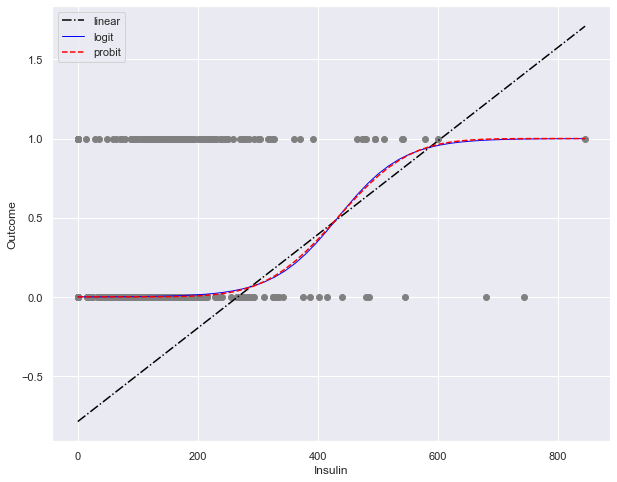

In [112]:
xInsulin = diab['Insulin']

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(xInsulin, y, color='grey', marker='o', linestyle='')
plt.plot(X_new['Insulin'], predictions_lin,
         color='black', linestyle='-.', label='linear')
plt.plot(X_new['Insulin'], predictions_logit,
         color='blue', linestyle='-', linewidth=1, label='logit')
plt.plot(X_new['Insulin'], predictions_probit,
         color='red', linestyle='--', label='probit')
plt.ylabel('Outcome')
plt.xlabel('Insulin')
plt.legend()

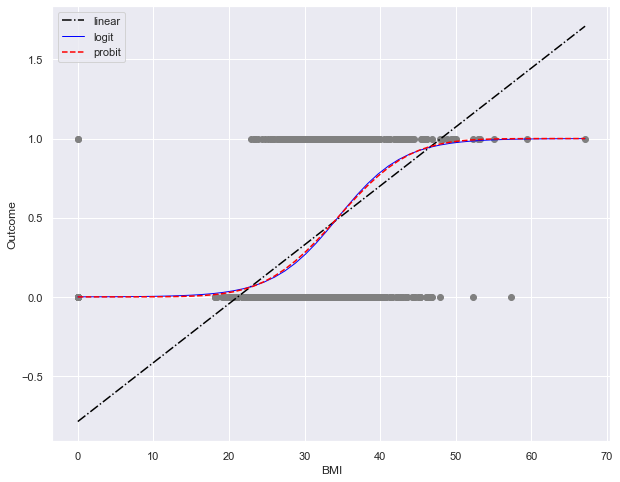

In [113]:
xBMI = diab['BMI']

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(xBMI, y, color='grey', marker='o', linestyle='')
plt.plot(X_new['BMI'], predictions_lin,
         color='black', linestyle='-.', label='linear')
plt.plot(X_new['BMI'], predictions_logit,
         color='blue', linestyle='-', linewidth=1, label='logit')
plt.plot(X_new['BMI'], predictions_probit,
         color='red', linestyle='--', label='probit')
plt.ylabel('Outcome')
plt.xlabel('BMI')
plt.legend()

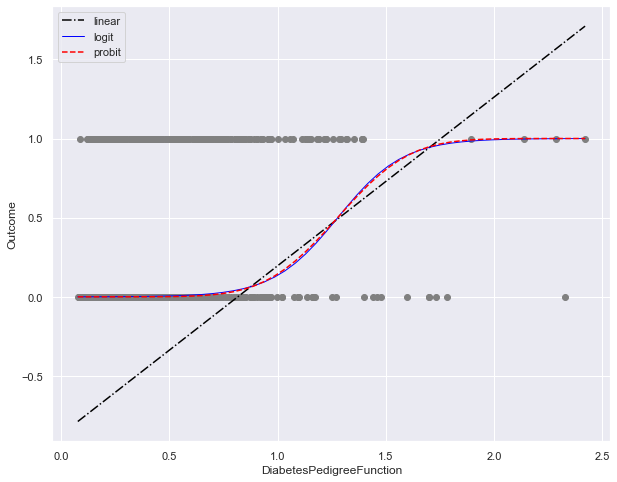

In [114]:
xDiabetesPedigreeFunction = diab['DiabetesPedigreeFunction']

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(xDiabetesPedigreeFunction, y, color='grey', marker='o', linestyle='')
plt.plot(X_new['DiabetesPedigreeFunction'], predictions_lin,
         color='black', linestyle='-.', label='linear')
plt.plot(X_new['DiabetesPedigreeFunction'], predictions_logit,
         color='blue', linestyle='-', linewidth=1, label='logit')
plt.plot(X_new['DiabetesPedigreeFunction'], predictions_probit,
         color='red', linestyle='--', label='probit')
plt.ylabel('Outcome')
plt.xlabel('DiabetesPedigreeFunction')
plt.legend()

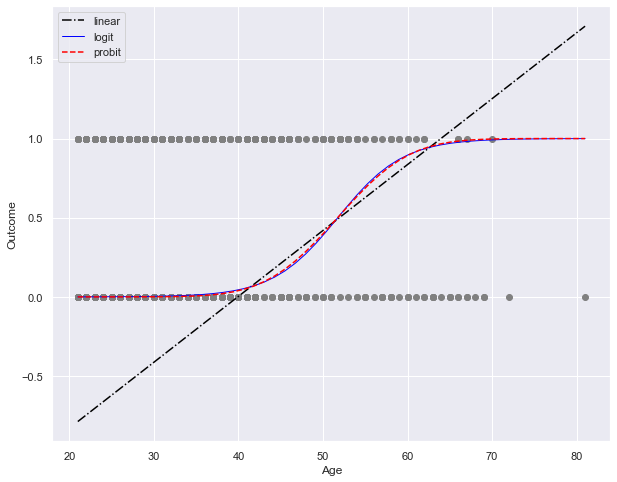

In [115]:
xAge = diab['Age']

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(xAge, y, color='grey', marker='o', linestyle='')
plt.plot(X_new['Age'], predictions_lin,
         color='black', linestyle='-.', label='linear')
plt.plot(X_new['Age'], predictions_logit,
         color='blue', linestyle='-', linewidth=1, label='logit')
plt.plot(X_new['Age'], predictions_probit,
         color='red', linestyle='--', label='probit')
plt.ylabel('Outcome')
plt.xlabel('Age')
plt.legend()

The linear probability model extends passed 0 and 1, so it is not the best model. Logit and Probit follow each other consistently and stay within the bounds.

In [118]:
from sklearn.linear_model import LogisticRegression #problem will be solved with scikit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score
import matplotlib.pyplot as plt

Linear Probability Model
[[398 102]
 [ 76 192]]


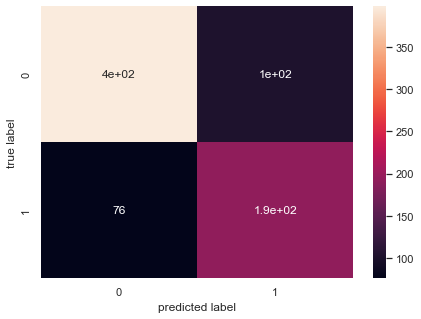

Probit
[[409  91]
 [ 88 180]]


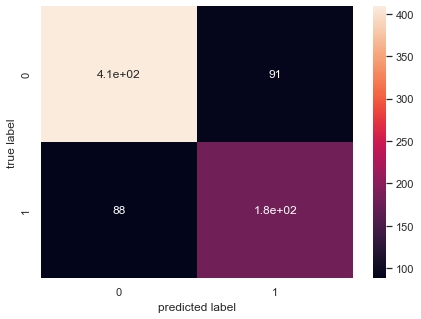

Logit
[[410  90]
 [ 88 180]]


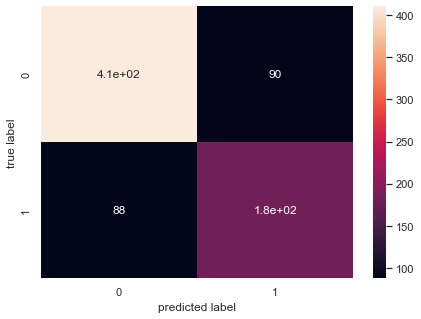

,Accuracy,Specificity,Sensitivity
LPM,0.768229,0.796,0.716418
Logit,0.766927,0.818,0.671642
Probit,0.768229,0.820,0.671642


In [119]:
# Creating the Confusion Matrix
threshold = 0.4

#### Confusion Matrix - Linear Probability Model
y_true = diab['Outcome']
y_pred = np.where(result_lin.fittedvalues > threshold, 1, 0)

conf_mat_lpm = confusion_matrix(y_true, y_pred)
print(red("Linear Probability Model", ['bold']))
print(conf_mat_lpm)
plt.figure(figsize = (7,5))
sns.heatmap(conf_mat_lpm, annot = True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

Accuracy = []
Specificity = []
Sensitivity = []

#  Accuracy, Specificity, and Sensitivity
total1=sum(sum(conf_mat_lpm))
Accuracy.append((conf_mat_lpm[0,0]+conf_mat_lpm[1,1])/total1)
Specificity.append(conf_mat_lpm[0,0]/(conf_mat_lpm[0,0]+conf_mat_lpm[0,1]))
Sensitivity.append(conf_mat_lpm[1,1]/(conf_mat_lpm[1,0]+conf_mat_lpm[1,1]))


#### Confusion Matrix - Probit Model
y_pred = np.where(result_probit.predict() > threshold, 1, 0)

conf_mat_probit = confusion_matrix(y_true, y_pred)
print(red("Probit", ['bold']))
print(conf_mat_probit)

plt.figure(figsize = (7,5))
sns.heatmap(conf_mat_probit, annot = True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# Accuracy, Specificity, and Sensitivity
total1=sum(sum(conf_mat_probit))
Accuracy.append((conf_mat_probit[0,0]+conf_mat_probit[1,1])/total1)
Specificity.append(conf_mat_probit[0,0]/(conf_mat_probit[0,0]+conf_mat_probit[0,1]))
Sensitivity.append(conf_mat_probit[1,1]/(conf_mat_probit[1,0]+conf_mat_probit[1,1]))


#### Confusion Matrix - Logit Model
y_pred = np.where(result_logit.predict() > threshold, 1, 0)

conf_mat_logit = confusion_matrix(y_true, y_pred)
print(red("Logit", ['bold']))
print(conf_mat_logit)

plt.figure(figsize = (7,5))
sns.heatmap(conf_mat_logit, annot = True)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# Accuracy, Specificity, and Sensitivity
total1=sum(sum(conf_mat_logit))
Accuracy.append((conf_mat_logit[0,0]+conf_mat_logit[1,1])/total1)
Specificity.append(conf_mat_logit[0,0]/(conf_mat_logit[0,0]+conf_mat_logit[0,1]))
Sensitivity.append(conf_mat_logit[1,1]/(conf_mat_logit[1,0]+conf_mat_logit[1,1]))


index = ["LPM", "Logit", "Probit"]
pd.DataFrame({'Accuracy': Accuracy,
             'Specificity': Specificity,
             'Sensitivity': Sensitivity},
            index = index)

The accuruacy for the probit model is the highest, as well as the specificity. The linear model has the highest sensitivity.

In [120]:
X_pred = pd.DataFrame(
    {'Pregnancies': [1, 3, 2, 7], 'Glucose': [123, 100, 105, 167],
     'BloodPressure': [96, 80, 100, 120], 'SkinThickness': [21, 17, 19, 30],
     'Insulin': [96, 70, 120, 138], 'BMI': [20, 19, 24, 40],'DiabetesPedigreeFunction': [.1, 1, .2, 1.8],
     'Age': [22, 43, 32, 67]})
predictions_probit = result_probit.predict(X_pred)
print(f'predictions_probit: \n{predictions_probit}\n')

predictions_probit: 
0    0.033526
1    0.081856
2    0.035314
3    0.947306
dtype: float64



The elderly person who is overweight most likely has diabetes. The other samples were either young or middle aged and did not have elevated levels of pregnancies, glucose, blood pressure, skin thickness, insulin, BMI nor diabetes pedigree function.

# Conclusion

The probit model had the accuracy for the confusion matrix. We set the threshold to be 0.4 because we figured it was better to have a false positive over a false negative. If someone has diabetes and is not treated, then they could die. If they do not have diabetes but are treated, they will not die. 0.4 threshold gave us the best accuracy overall. The linear model does not stay within the bounds of 0 and 1. While the logit model is easier to solve numerically, the probit model gives us the highest accuracy even though they are very similar. Since we chose the probit model, the likely person to have diabetes among our four predictions is an obese elderly person. They have more children, glucose, blood pressure, insulin, skin thickness and diabetes pedigree function as well compared to our other samples.